In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from paths import *

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
df_comments = pd.read_csv(OUTPUT_PATH / 'joined_comments.csv')
df_submissions = pd.read_csv(OUTPUT_PATH / 'joined_submissions.csv')

In [8]:
df_comments.head()

,author,subreddit,score,created,link,body
0,u/lisztomania_0,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,It is an über talent that has become an über t...
1,u/JakeTheSandMan,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,“Armada” \n\nI prefer to call them floating hu...
2,u/justnmirrrs,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,"70% of France electricity is nuclear, so it co..."
3,u/liquid_cherry,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,In the United States you can burn the Bible an...
4,u/Grouchy-Bad-4190,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,Good


In [9]:
df_submissions.head()

,author,subreddit,title,num_comments,score,over_18,created,link,text,url
0,u/BurstYourBubbles,worldnews,"S. Korean, Italian FMs hold talks on boosting ...",0.000150,0.000019,False,2023-08-01 03:24,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://en.yna.co.kr/view/AEN20230801001000325?
1,u/BurstYourBubbles,worldnews,Hong Kong gov't would face 'difficulty' if it ...,0.000075,0.000019,False,2023-08-01 03:26,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://hongkongfp.com/2023/08/01/hong-kong-go...
2,u/kurdishgun,AskMiddleEast,Thoughts on exmuslim?,0.004198,0.000019,False,2023-08-01 03:31,https://www.reddit.com/r/AskMiddleEast/comment...,NaN,https://i.redd.it/mmy60for8efb1.png
3,u/TypicalHorror9,worldnews,Professional dancer pumping gas in NYC stabbed...,0.000000,0.000019,False,2023-08-01 03:41,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://www.nydailynews.com/new-york/nyc-crime...
4,u/mrwhiskeyrum,worldnews,Frequent dispatch of ships and aircraft by cer...,0.000899,0.000019,False,2023-08-01 03:44,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://newsinfo.inquirer.net/1809492/foreign-...



### 1. Correlation: Israel-Gaza Conflict and r/worldnews Commenting Activity

Those charts track the daily volume of unique comments posted on the r/worldnews subreddit. They highlight a strong and direct correlation between a major geopolitical event and online engagement.

First one shows the total daily volume of all unique comments submitted to the r/worldnews subreddit, regardless of topic, demonstrating the overall community reaction to the crisis.

The second chart (below) refines this view by only including comments that explicitly mention keywords related to the conflict (Gaza, Palestine, Israel, Hamas), thereby isolating the volume of discussion specifically centered on this event.


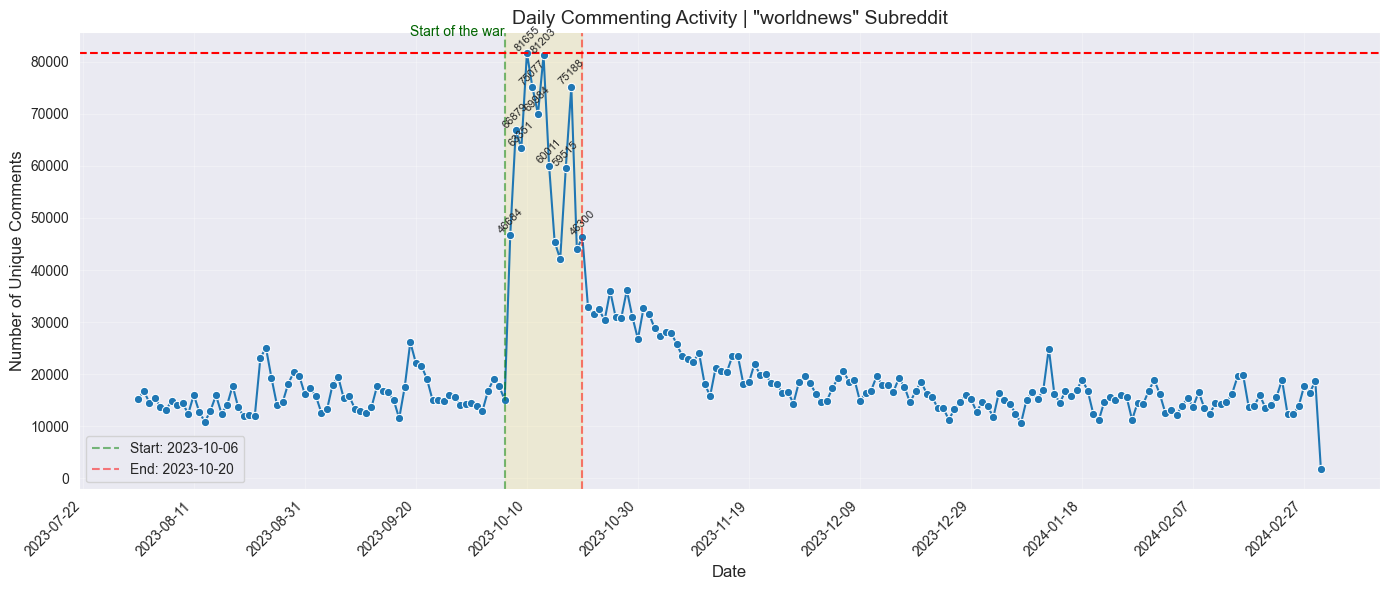

In [10]:
filtered_df = df_comments[df_comments['subreddit'] == 'worldnews'].copy()
filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')

filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

daily_counts = filtered_df['date'].value_counts().sort_index()
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Comment_Count', data=daily_counts_df, marker='o')

threshold = daily_counts_df['Comment_Count'].quantile(0.95)

above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date = above_threshold['Date'].min() - timedelta(days=1)
last_date = above_threshold['Date'].max()

plt.axvline(first_date, color='green', linestyle='--', alpha=0.5, label=f'Start: {first_date}')
plt.axvline(last_date, color='red', linestyle='--', alpha=0.5, label=f'End: {last_date}')
plt.axvspan(first_date, last_date, color='khaki', alpha=0.3)

plt.text(first_date, daily_counts_df['Comment_Count'].max() * 1.05, 'Start of the war',
         color='darkgreen', ha='right', va='center', fontsize=10, rotation=0)

for idx, row in daily_counts_df.iterrows():
    if row['Comment_Count'] > threshold:
        plt.text(row['Date'], row['Comment_Count'], str(row['Comment_Count']),
                ha='center', va='bottom', fontsize=8, rotation=45)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))  # Max 15 date labels
plt.axhline(y=daily_counts_df['Comment_Count'].max(), color='r', linestyle='--')

plt.title('Daily Commenting Activity | "worldnews" Subreddit', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Comments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

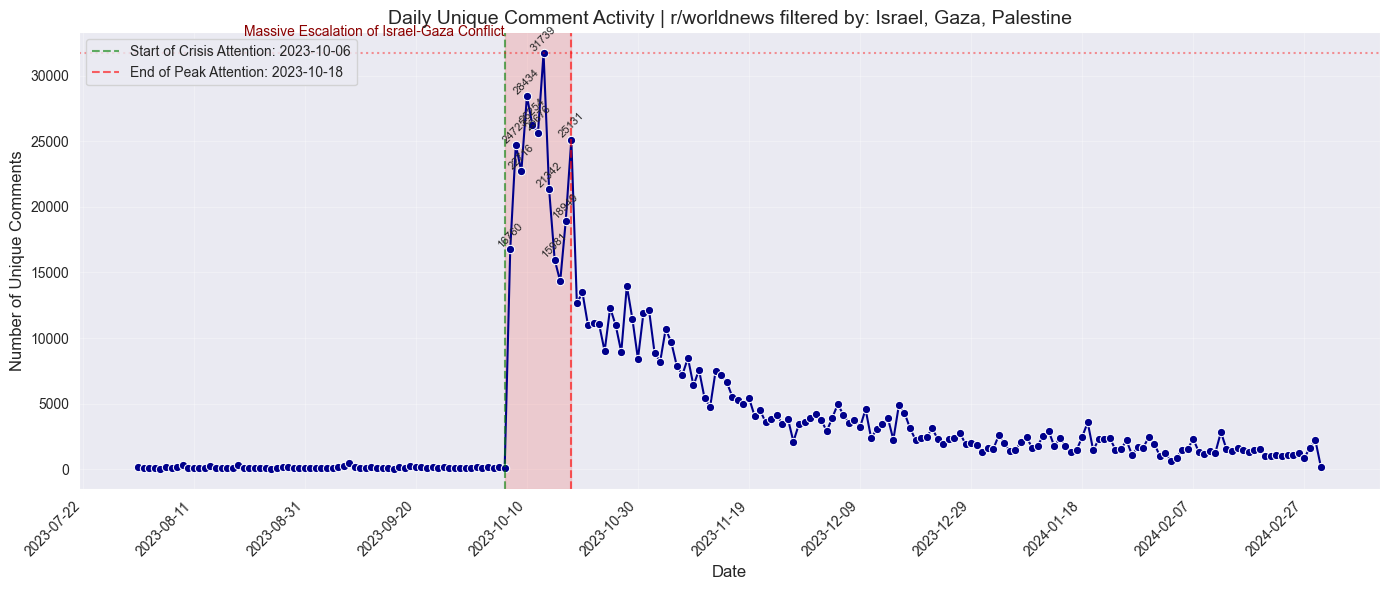

In [11]:
keywords = 'Gaza|Palestine|Israel|Hamas'

# Filtration
filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()

# date -> datetime
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

# Unique comments count
daily_counts = filtered_df['date'].value_counts().sort_index()
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']

# Visualisation
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Comment_Count', data=daily_counts_df, marker='o', color='darkblue')

threshold = daily_counts_df['Comment_Count'].quantile(0.95)
above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()

    plt.axvline(first_date, color='green', linestyle='--', alpha=0.6, label=f'Start of Crisis Attention: {first_date}')
    plt.axvline(last_date, color='red', linestyle='--', alpha=0.6, label=f'End of Peak Attention: {last_date}')
    plt.axvspan(first_date, last_date, color='lightcoral', alpha=0.3)

    max_y = daily_counts_df['Comment_Count'].max()
    plt.text(first_date, max_y * 1.05, 'Massive Escalation of Israel-Gaza Conflict',
             color='darkred', ha='right', va='center', fontsize=10, rotation=0)

    for idx, row in daily_counts_df.iterrows():
        if row['Comment_Count'] > threshold:
            plt.text(row['Date'], row['Comment_Count'], str(row['Comment_Count']),
                    ha='center', va='bottom', fontsize=8, rotation=45)
else:
    print("Warning: Not enough data points exceeded the 95th percentile threshold to highlight a period.")


plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.axhline(y=daily_counts_df['Comment_Count'].max(), color='red', linestyle=':', alpha=0.4)

plt.title('Daily Unique Comment Activity | r/worldnews filtered by: Israel, Gaza, Palestine', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Comments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

#### 2. Sentiment Dynamics: Discussion About “Israel” and "Hamas" in r/worldnews

The three stacked line plots visualize how user sentiment fluctuated throughout the observed period:

Positive Sentiment (Top Chart): Tracks expressions of support, optimism, or diplomatic hope in the discussion. Occasional peaks may align with ceasefire announcements or humanitarian news.

Neutral Sentiment (Middle Chart): Represents factual or news-style commentary, typically the largest share of daily sentiment, indicating that most discussions remain informational rather than emotional.

Negative Sentiment (Bottom Chart): Captures anger, criticism, and frustration — often spiking around escalation dates or major violent events.

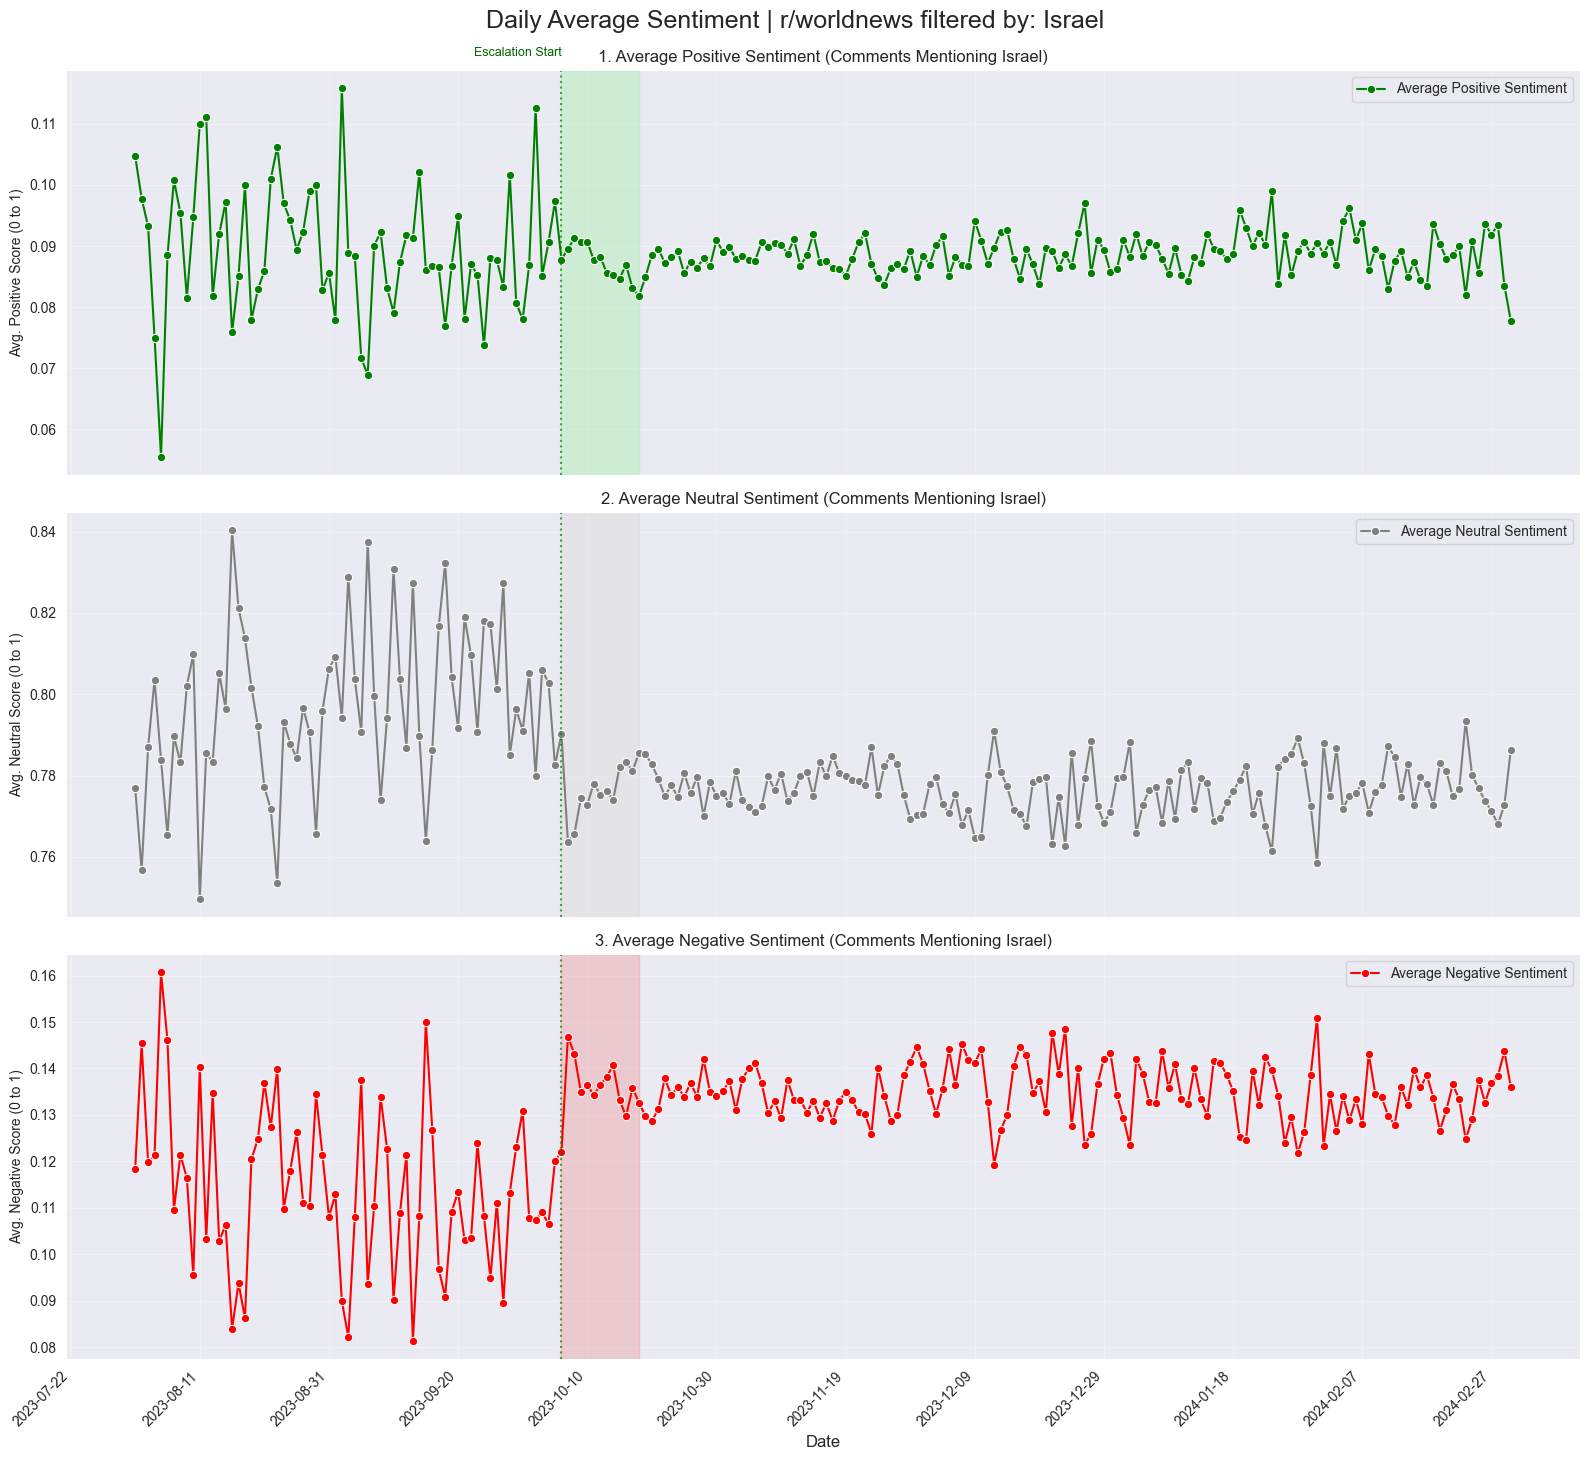

In [12]:
# Filtration and analysis

keywords = 'Israel'

filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()

filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

sia = SentimentIntensityAnalyzer()

filtered_df['sentiment_scores'] = filtered_df['body'].apply(lambda x: sia.polarity_scores(str(x)))
filtered_df['Negative'] = filtered_df['sentiment_scores'].apply(lambda x: x['neg'])
filtered_df['Neutral'] = filtered_df['sentiment_scores'].apply(lambda x: x['neu'])
filtered_df['Positive'] = filtered_df['sentiment_scores'].apply(lambda x: x['pos'])

daily_sentiment = filtered_df.groupby('date')[['Positive', 'Neutral', 'Negative']].mean().reset_index()
daily_sentiment.columns = ['Date', 'Positive', 'Neutral', 'Negative']

daily_counts_df = filtered_df['date'].value_counts().reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']
threshold = daily_counts_df['Comment_Count'].quantile(0.95)
above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date, last_date = None, None
if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()


# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(16, 15), sharex=True)

plt.suptitle('Daily Average Sentiment | r/worldnews filtered by: Israel',
             fontsize=18, y=0.97)

# Positive
sns.lineplot(ax=axes[0], x='Date', y='Positive', data=daily_sentiment, color='green', marker='o', label='Average Positive Sentiment')
axes[0].set_title('1. Average Positive Sentiment (Comments Mentioning Israel)', fontsize=12)
axes[0].set_ylabel('Avg. Positive Score (0 to 1)')
axes[0].grid(True, alpha=0.3)
if first_date:
    axes[0].axvspan(first_date, last_date, color='lightgreen', alpha=0.3)
    axes[0].axvline(first_date, color='green', linestyle=':', alpha=0.7)
    axes[0].text(first_date, daily_sentiment['Positive'].max() * 1.05, 'Escalation Start',
                 color='darkgreen', ha='right', va='center', fontsize=9, rotation=0)

# Neutral
sns.lineplot(ax=axes[1], x='Date', y='Neutral', data=daily_sentiment, color='gray', marker='o', label='Average Neutral Sentiment')
axes[1].set_title('2. Average Neutral Sentiment (Comments Mentioning Israel)', fontsize=12)
axes[1].set_ylabel('Avg. Neutral Score (0 to 1)')
axes[1].grid(True, alpha=0.3)
if first_date:
    axes[1].axvspan(first_date, last_date, color='lightgray', alpha=0.3)
    axes[1].axvline(first_date, color='green', linestyle=':', alpha=0.7)

# Negative
sns.lineplot(ax=axes[2], x='Date', y='Negative', data=daily_sentiment, color='red', marker='o', label='Average Negative Sentiment')
axes[2].set_title('3. Average Negative Sentiment (Comments Mentioning Israel)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Avg. Negative Score (0 to 1)')
axes[2].grid(True, alpha=0.3)
if first_date:
    axes[2].axvspan(first_date, last_date, color='lightcoral', alpha=0.3)
    axes[2].axvline(first_date, color='green', linestyle=':', alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.93)
plt.show()

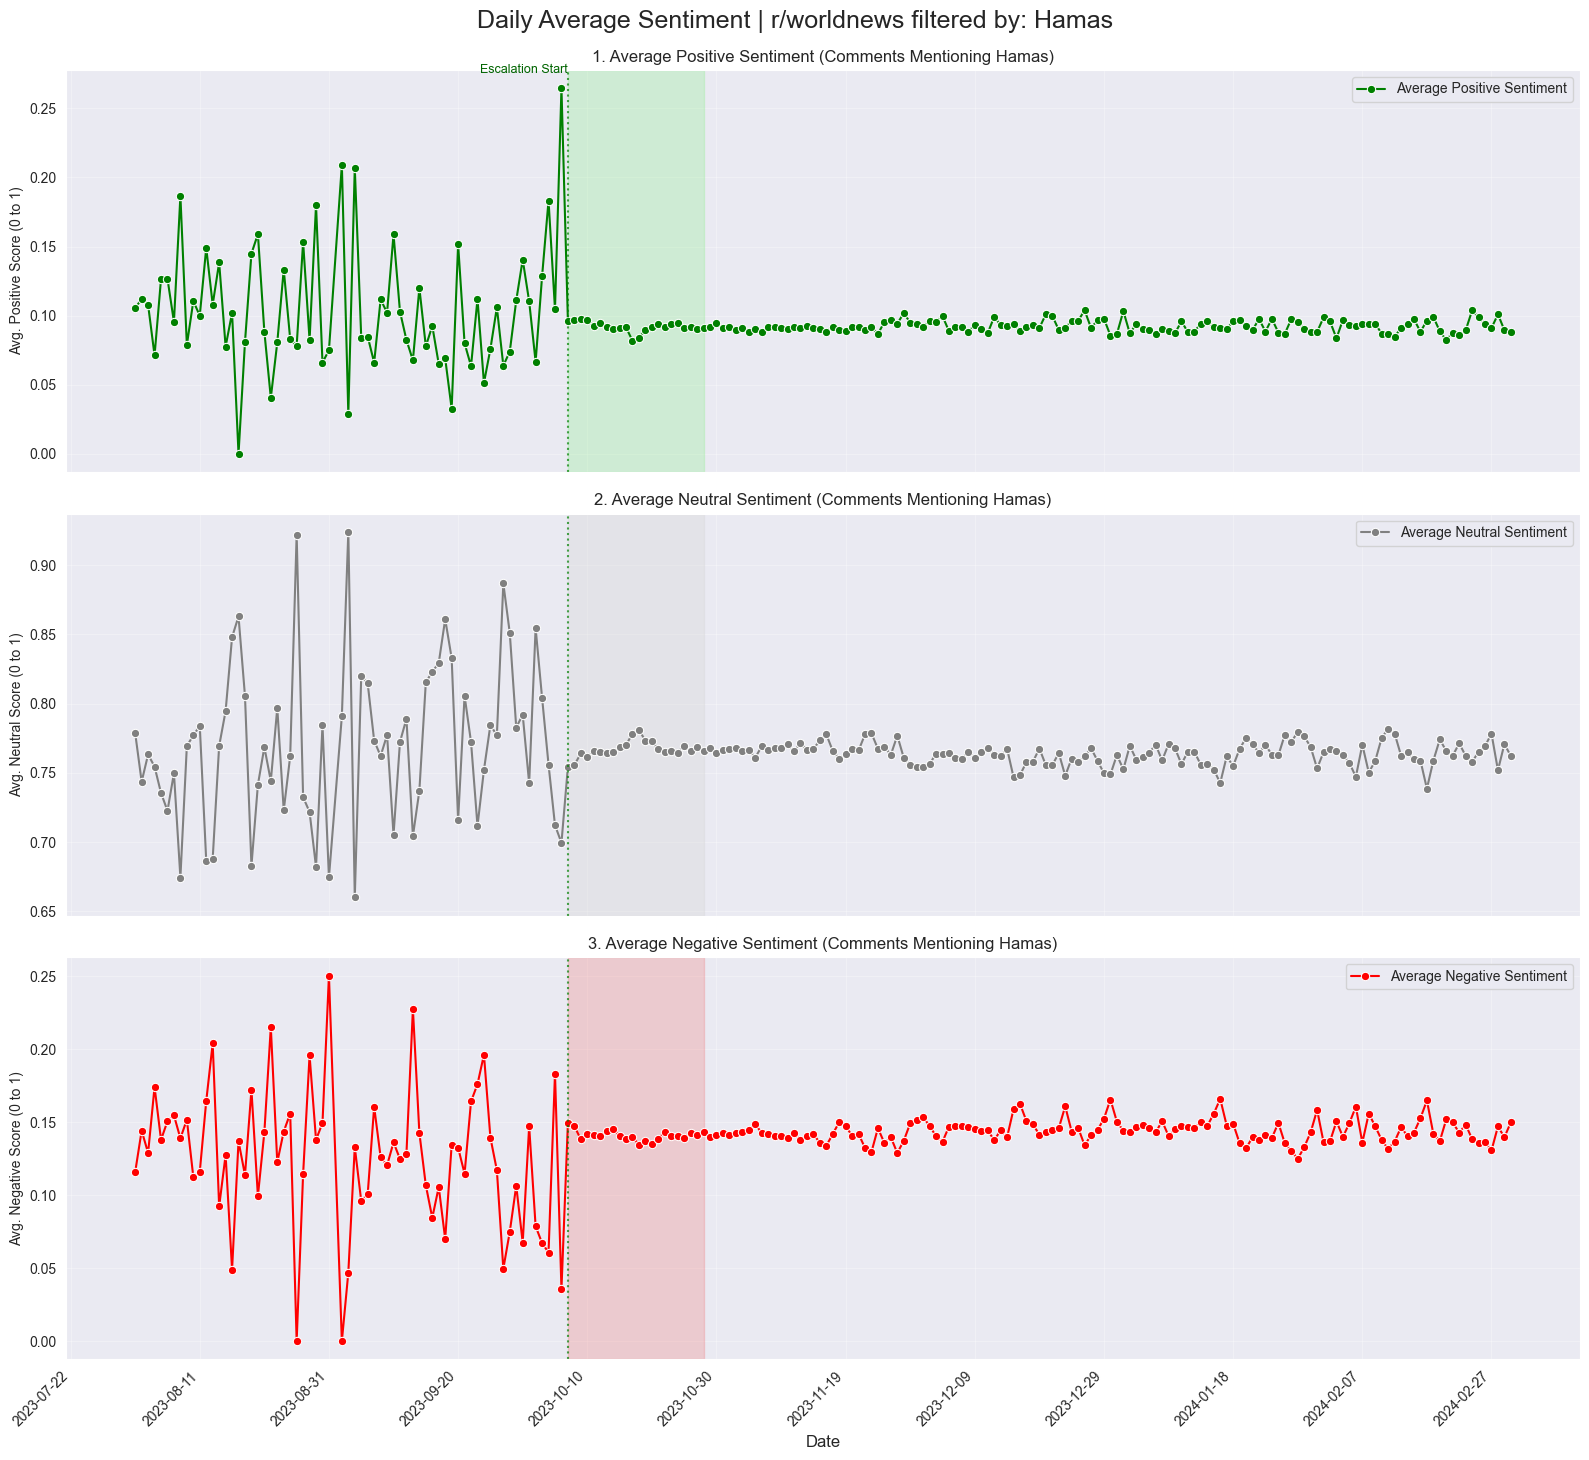

In [13]:
# Filtration and analysis

keywords = 'Hamas'

filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()

filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

sia = SentimentIntensityAnalyzer()

filtered_df['sentiment_scores'] = filtered_df['body'].apply(lambda x: sia.polarity_scores(str(x)))
filtered_df['Negative'] = filtered_df['sentiment_scores'].apply(lambda x: x['neg'])
filtered_df['Neutral'] = filtered_df['sentiment_scores'].apply(lambda x: x['neu'])
filtered_df['Positive'] = filtered_df['sentiment_scores'].apply(lambda x: x['pos'])

daily_sentiment = filtered_df.groupby('date')[['Positive', 'Neutral', 'Negative']].mean().reset_index()
daily_sentiment.columns = ['Date', 'Positive', 'Neutral', 'Negative']

daily_counts_df = filtered_df['date'].value_counts().reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']
threshold = daily_counts_df['Comment_Count'].quantile(0.95)
above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date, last_date = None, None
if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()


# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(16, 15), sharex=True)

plt.suptitle('Daily Average Sentiment | r/worldnews filtered by: Hamas',
             fontsize=18, y=0.97)

# Positive
sns.lineplot(ax=axes[0], x='Date', y='Positive', data=daily_sentiment, color='green', marker='o', label='Average Positive Sentiment')
axes[0].set_title('1. Average Positive Sentiment (Comments Mentioning Hamas)', fontsize=12)
axes[0].set_ylabel('Avg. Positive Score (0 to 1)')
axes[0].grid(True, alpha=0.3)
if first_date:
    axes[0].axvspan(first_date, last_date, color='lightgreen', alpha=0.3)
    axes[0].axvline(first_date, color='green', linestyle=':', alpha=0.7)
    axes[0].text(first_date, daily_sentiment['Positive'].max() * 1.05, 'Escalation Start',
                 color='darkgreen', ha='right', va='center', fontsize=9, rotation=0)

# Neutral
sns.lineplot(ax=axes[1], x='Date', y='Neutral', data=daily_sentiment, color='gray', marker='o', label='Average Neutral Sentiment')
axes[1].set_title('2. Average Neutral Sentiment (Comments Mentioning Hamas)', fontsize=12)
axes[1].set_ylabel('Avg. Neutral Score (0 to 1)')
axes[1].grid(True, alpha=0.3)
if first_date:
    axes[1].axvspan(first_date, last_date, color='lightgray', alpha=0.3)
    axes[1].axvline(first_date, color='green', linestyle=':', alpha=0.7)

# Negative
sns.lineplot(ax=axes[2], x='Date', y='Negative', data=daily_sentiment, color='red', marker='o', label='Average Negative Sentiment')
axes[2].set_title('3. Average Negative Sentiment (Comments Mentioning Hamas)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Avg. Negative Score (0 to 1)')
axes[2].grid(True, alpha=0.3)
if first_date:
    axes[2].axvspan(first_date, last_date, color='lightcoral', alpha=0.3)
    axes[2].axvline(first_date, color='green', linestyle=':', alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.93)
plt.show()

# EDA & Graph Analysis: Assumptions and Hypotheses

#### Goal 1: Tone/Sentiment Comparison

1.  **Baseline Polarization:** The baseline sentiment (Aug-Sep 2023) in `r/Israel` for posts mentioning "Israel" will be positive, while the baseline sentiment in `r/Palestine` for posts mentioning "Palestine" will also be positive. However, the sentiment for *crossposted* terms (e.g., "Palestine" in `r/Israel`) will be highly negative, showing strong "in-group" vs. "out-group" sentiment.
2.  **Echo Chamber vs. Debate:** The sentiment *variance* (statistical measure of spread) in `r/IsraelPalestine` will be significantly higher than in `r/Israel` or `r/Palestine`, indicating it functions as a "battleground" or debate forum rather than an echo chamber.
3.  **Specialized Subreddits:** The average sentiment in `r/IsraelCrimes` and `r/israelexposed` will be the most negative of the entire dataset, even more so than `r/Palestine`, and will show less volatility (i.e., it is *consistently* negative).

#### Goal 2: Sentiment Dynamics Over Time

4.  **Volume vs. Sentiment:** The spike in daily comment *volume* (as seen in your notebook) will be strongly correlated with a sharp *drop* in the daily *average sentiment* for all keywords ("Israel," "Hamas," "Gaza," "Palestine").
5.  **Positive Event Spikes:** While the overall sentiment trend will be negative, the daily *count* of positive-sentiment comments will show brief, sharp spikes that correspond to specific dates of announced humanitarian aid deliveries or hostage/prisoner exchanges.
6.  **Keyword Sentiment Divergence:** The average sentiment for comments mentioning "Hamas" will be consistently and strongly negative. In contrast, the sentiment for "Israel" will be more volatile, showing both negative spikes (related to military actions) and positive spikes (related to "defense," "security," or "hostage rescue").

#### Goal 3: Citing News Sources

7.  **Source Partisanship:** Submissions in `r/Israel` will disproportionately cite Israeli and Western news domains (e.g., `jpost.com`, `timesofisrael.com`, `bbc.com`), while submissions in `r/Palestine` will have a significantly higher proportion of citations from sources like `aljazeera.com`, `haaretz.com`, and `middleeasteye.net`.
8.  **Engagement vs. Source:** In `r/worldnews`, the submissions with the highest `score` or `num_comments` will *not* be from the most-cited mainstream sources (like Reuters or AP) but from more opinionated or visually-driven sources (e.g., specific op-eds, video sites).

#### Goal 4: Word Frequency Analysis

9.  **Keyword Co-occurrence:** The frequency of the word "Hezbollah" in comments from `r/Lebanon` and `r/worldnews` will be near-zero in Aug-Sep 2023 and will spike significantly after the initial October 7 escalation.
10. **Temporal Keyword Shift:** A time-series analysis of n-gram frequency will show a shift. In Oct-Nov 2023, the most frequent bigrams related to the conflict will be "Hamas attack" and "hostage." In Jan-Feb 2024, this will shift to "humanitarian aid," "ceasefire," and "famine."
11. **NSFW Content:** The proportion of submissions marked `over_18` will spike in `r/worldnews` and `r/IsraelCrimes` immediately after October 7, and these posts will correlate with a significantly higher negative sentiment.

#### Goal 5: Semantic Evolution & Graph Analysis

12. **Topic Modeling (LDA):** Topic modeling on the `body` of `r/worldnews` comments will show a dominant "conflict" topic (Gaza, Israel, Hamas, attack) emerging in October 2023 that was absent in Aug/Sep.
13. **Graph (Echo Chambers):** A graph where **nodes are authors** and **edges are replies** will show high modularity (clustering) within `r/Israel` and `r/Palestine`. Users will almost exclusively reply to other users with similar sentiment, forming distinct echo chambers. This clustering will be *lower* in `r/IsraelPalestine`.
14. **Graph (Polarization):** In `r/worldnews`, a two-mode graph of (Authors) -> (Submissions) will reveal two large, disconnected clusters of users (those who comment on pro-Israel posts vs. those who comment on pro-Palestine posts). "Bridging" users who comment on both sets of submissions will be rare.
15. **Graph (Power Users):** In the `r/worldnews` user-reply graph, the nodes with the highest **degree centrality** (most replies) during the conflict period will also be the authors with the most negative average sentiment.
16. **Graph (Timezone Activity):** By inferring user timezones from `created` timestamps, a graph analysis will show that during the conflict spike (post-Oct 7), reply activity becomes *less* clustered by timezone. This suggests users are engaging across timezones (i.e., staying up late) more than during the baseline period.
17. **Graph (Ideological Bridging):** In the user-reply graph for `r/IsraelPalestine`, identify users with high **betweenness centrality**. These "bridging" users, who connect otherwise separate communities, will have an average sentiment score closer to neutral than the highly polarized users they connect.